In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import interp

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, label_binarize, LabelBinarizer
from sklearn.metrics import r2_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import catboost as cb
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

Корректируем датасет:  
1) корректировка используемого в модели значения капитализации и разницы логарифмов между раундами  
2) исключение раундов "без ответа"  
3) приведение дат к нужному формату

In [2]:
nan = [np.nan]
default_exit_value = 1 #"капитализация" мертвой компании в долларах

In [3]:
#wave_1
dataset = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_1/2_SocialGraph/people_one_hot.csv')
dataset = dataset.iloc[1:]
dataset = dataset.rename(columns={'experience_in_months': 'exp_months_min', 'experience_in_months.1': 'exp_months_max', 'experience_in_months.2': 'exp_months_mean', 'experience_in_months.3': 'exp_months_std', 'is_PHD': 'PHD_count', 'is_Master': 'Master_count', 'is_MBA': 'MBA_count', 'top_quantil': 'from_top5_count'})
dataset

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_2009,time_from_start,time_from_previous,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,total_count,count_per_round,from_top5_count,PHD_count,Master_count,MBA_count,exp_months_min,exp_months_max,exp_months_mean,exp_months_std
1,778db45f-e9d1-3f73-86f4-ae4cc79c48ff,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,seed,2010-01-01,500000.0,---,---,---,---,---,365.0,0.0,---,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,9.0,2.0,0.0,0.0,1.0,1.0,135.0335735846732,199.03488778003654,167.03423068235486,45.25576327239227
2,fc2c2560-8bb0-90d1-b048-ee9cfc3f301d,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_a,2010-11-10,3000000.0,---,---,---,---,---,678.0,313.0,313.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,9.0,3.0,0.0,0.0,1.0,1.0,53.32347686810817,209.31846649828537,135.9863652231052,78.4149659700011
3,d863a1b9-dda0-284e-3258-fa43a20d305c,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_b,2011-05-02,10000000.0,---,---,---,---,---,851.0,486.0,173.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,9.0,4.0,0.0,0.0,2.0,2.0,0.0,215.00236144479354,106.25269512721,95.48239059035497
4,4c9cb685-ec9a-92ed-64c0-062040d9573e,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_unknown,2011-08-24,1000000.0,---,---,---,---,---,965.0,600.0,114.0,0.0,1.0,3.0,2.0,6.0,2.0,3.0,1.0,9.0,4.0,0.0,0.0,2.0,2.0,0.0,218.7478182303538,109.06178771638022,96.8798428111566
5,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,30000000.0,---,---,---,---,---,1037.0,672.0,72.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,9.0,4.0,0.0,0.0,2.0,2.0,0.0,221.1133698843919,110.83595145690877,97.7706351449893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,80f5449a-2b38-f3eb-dc4f-d5b581e636ec,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_unknown,2010-12-14,1195972.0,---,2014-06-19,ipo,300000000.0,112000000.0,712.0,0.0,---,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,9.0,6.0,2.0,1.0,0.0,1.0,0.0,426.45639540852994,140.553194110762,176.5474614109795
3730,e79c29e1-b5a7-db70-014d-36c2ba16338b,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_unknown,2010-12-20,792000.0,---,2014-06-19,ipo,300000000.0,112000000.0,718.0,6.0,6.0,0.0,1.0,4.0,6.0,5.0,11.0,2.0,3.0,9.0,6.0,2.0,1.0,0.0,1.0,0.0,426.6535247130331,140.6517587630136,176.64163261454254
3731,2067db69-a274-7914-0207-5fb1af6cc7ca,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_c,2012-10-23,46000000.0,---,2014-06-19,ipo,300000000.0,112000000.0,1391.0,679.0,673.0,1.0,1.0,4.0,6.0,5.0,11.0,2.0,3.0,9.0,6.0,2.0,1.0,0.0,1.0,0.0,448.7648617014723,151.7074272572332,187.2990599629018
3732,602347ee-2d81-7ad3-7f85-d68ea1fb8967,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_d,2014-03-05,55000000.0,---,2014-06-19,ipo,300000000.0,112000000.0,1889.0,1177.0,498.0,1.0,1.0,4.0,6.0,5.0,11.0,2.0,3.0,9.0,9.0,3.0,2.0,1.0,3.0,0.0,465.1265939752356,210.17999456981775,176.69071802996686


In [4]:
dataset['raised_amount_usd'] = pd.to_numeric(dataset['raised_amount_usd'], errors='coerce')
dataset.loc[dataset['raised_amount_usd'].isin(nan), 'raised_amount_usd'] = 0
dataset['interpolated_money_valuation_usd'] = round(dataset['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
dataset['interpolated_money_valuation_usd'] = pd.to_numeric(dataset['interpolated_money_valuation_usd'], errors='coerce')
dataset.loc[dataset['interpolated_money_valuation_usd'].isin(nan), 'interpolated_money_valuation_usd'] = 0
dataset['post_money_valuation_usd'] = pd.to_numeric(dataset['post_money_valuation_usd'], errors='coerce')
dataset.loc[dataset['post_money_valuation_usd'].isin(nan), 'post_money_valuation_usd'] = 0

dataset.loc[dataset['time_from_previous'].isin(nan), 'time_from_previous'] = 0
dataset['total_sum_raised'] = dataset.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
dataset['total_sum_raised_before'] = dataset.groupby('company_uuid')['total_sum_raised'].shift(1)
dataset.loc[dataset['total_sum_raised_before'].isin(nan), 'total_sum_raised_before'] = 0

dataset['valuation'] = dataset['interpolated_money_valuation_usd']
dataset.loc[dataset['valuation'] == 0, 'valuation'] = dataset['post_money_valuation_usd']
dataset.loc[dataset['investment_type'] == 'death', 'valuation'] = default_exit_value

dataset = dataset.replace('---', np.nan)
dataset.loc[(dataset['exit_type'].isin(nan)) | (dataset['exit_type'] == '0'), 'exit_type'] = 'dead'
dataset.loc[dataset['exit_type'] == 'dead', 'not_dead'] = 0
dataset.loc[dataset['exit_type'].isin(['sold', 'ipo']), 'not_dead'] = 1

dataset['announced_on'] = pd.to_datetime(dataset['announced_on'])
dataset['time_from_previous'] = pd.to_numeric(dataset['time_from_previous'], errors='coerce')

listColumns = ['from_top5_count', 'PHD_count', 'Master_count', 'MBA_count']
for i in listColumns:
    dataset[i] = dataset[i].replace(np.nan, 0)

#for i in dataset.columns:
#    if i.startswith('EDU_'):
#        dataset[i] = pd.to_numeric(dataset[i], errors='coerce')
#        dataset.loc[dataset[i] != 0, i] = 1

y = dataset.loc[dataset['investment_type'].isin(['ipo', 'sold', 'death'])] #экзиты
dataset

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_2009,time_from_start,time_from_previous,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,total_count,count_per_round,from_top5_count,PHD_count,Master_count,MBA_count,exp_months_min,exp_months_max,exp_months_mean,exp_months_std,interpolated_money_valuation_usd,total_sum_raised,total_sum_raised_before,valuation,not_dead
1,778db45f-e9d1-3f73-86f4-ae4cc79c48ff,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,seed,2010-01-01,500000.0,0.0,NaN,dead,NaN,NaN,365.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,9.0,2.0,0.0,0.0,1.0,1.0,135.0335735846732,199.03488778003654,167.03423068235486,45.25576327239227,2.000000e+06,500000.0,0.0,2.000000e+06,0.0
2,fc2c2560-8bb0-90d1-b048-ee9cfc3f301d,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_a,2010-11-10,3000000.0,0.0,NaN,dead,NaN,NaN,678.0,313.0,313.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,9.0,3.0,0.0,0.0,1.0,1.0,53.32347686810817,209.31846649828537,135.9863652231052,78.4149659700011,1.800000e+07,3500000.0,500000.0,1.800000e+07,0.0
3,d863a1b9-dda0-284e-3258-fa43a20d305c,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_b,2011-05-02,10000000.0,0.0,NaN,dead,NaN,NaN,851.0,486.0,173.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,9.0,4.0,0.0,0.0,2.0,2.0,0.0,215.00236144479354,106.25269512721,95.48239059035497,6.800000e+07,13500000.0,3500000.0,6.800000e+07,0.0
4,4c9cb685-ec9a-92ed-64c0-062040d9573e,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_unknown,2011-08-24,1000000.0,0.0,NaN,dead,NaN,NaN,965.0,600.0,114.0,0.0,1.0,3.0,2.0,6.0,2.0,3.0,1.0,9.0,4.0,0.0,0.0,2.0,2.0,0.0,218.7478182303538,109.06178771638022,96.8798428111566,5.000000e+06,14500000.0,13500000.0,5.000000e+06,0.0
5,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,30000000.0,0.0,NaN,dead,NaN,NaN,1037.0,672.0,72.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,9.0,4.0,0.0,0.0,2.0,2.0,0.0,221.1133698843919,110.83595145690877,97.7706351449893,2.320000e+08,44500000.0,14500000.0,2.320000e+08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,80f5449a-2b38-f3eb-dc4f-d5b581e636ec,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_unknown,2010-12-14,1195972.0,0.0,2014-06-19,ipo,300000000.0,112000000.0,712.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,9.0,6.0,2.0,1.0,0.0,1.0,0.0,426.45639540852994,140.553194110762,176.5474614109795,6.000000e+06,1195972.0,0.0,6.000000e+06,1.0
3730,e79c29e1-b5a7-db70-014d-36c2ba16338b,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_unknown,2010-12-20,792000.0,0.0,2014-06-19,ipo,300000000.0,112000000.0,718.0,6.0,6.0,0.0,1.0,4.0,6.0,5.0,11.0,2.0,3.0,9.0,6.0,2.0,1.0,0.0,1.0,0.0,426.6535247130331,140.6517587630136,176.64163261454254,4.000000e+06,1987972.0,1195972.0,4.000000e+06,1.0
3731,2067db69-a274-7914-0207-5fb1af6cc7ca,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_c,2012-10-23,46000000.0,0.0,2014-06-19,ipo,300000000.0,112000000.0,1391.0,679.0,673.0,1.0,1.0,4.0,6.0,5.0,11.0,2.0,3.0,9.0,6.0,2.0,1.0,0.0,1.0,0.0,448.7648617014723,151.7074272572332,187.2990599629018,3.740000e+08,47987972.0,1987972.0,3.740000e+08,1.0
3732,602347ee-2d81-7ad3-7f85-d68ea1fb8967,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_d,2014-03-05,55000000.0,0.0,2014-06-19,ipo,300000000.0,112000000.0,1889.0,1177.0,498.0,1.0,1.0,4.0,6.0,5.0,11.0,2.0,3.0,9.0,9.0,3.0,2.0,1.0,3.0,0.0,465.1265939752356,210.17999456981775,176.69071802996686,4.560000e+08,102987972.0,47987972.0,4.560000e+08,1.0


Разбиваем на классы

In [5]:
# y['val_rate'].describe([.5])

In [6]:
# y.groupby('investment_type').size()

Все, что слева от медианного значения -0.9 - нарвалы (с отрицательной скоростью роста привлеченных средств), справа - носороги (с положительной и околонулевой скоростью роста привлеченных средств)

In [7]:
dataset = dataset.loc[dataset['company_uuid'].isin(y['company_uuid'].values)]
# dataset.loc[dataset.groupby('company_uuid')['val_rate'].shift(-1) <= -0.916257, 'class'] = 'narwhal'
# dataset.loc[dataset.groupby('company_uuid')['val_rate'].shift(-1) > -0.916257, 'class'] = 'rhino'

additional = dataset.set_index('funding_round_uuid').groupby('company_uuid')['announced_on'].nlargest(2).reset_index()
dataset = dataset.loc[dataset['funding_round_uuid'].isin(additional['funding_round_uuid'].values)]
# exits = dataset.copy()
dataset = dataset.loc[~dataset['investment_type'].isin(['ipo', 'sold', 'death'])] #преэкзиты
dataset

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_2009,time_from_start,time_from_previous,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,total_count,count_per_round,from_top5_count,PHD_count,Master_count,MBA_count,exp_months_min,exp_months_max,exp_months_mean,exp_months_std,interpolated_money_valuation_usd,total_sum_raised,total_sum_raised_before,valuation,not_dead
5,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,30000000.0,0.000000e+00,NaN,dead,NaN,NaN,1037.0,672.0,72.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,9.0,4.0,0.0,0.0,2.0,2.0,0.0,221.1133698843919,110.83595145690877,97.7706351449893,2.320000e+08,44500000.0,14500000.0,2.320000e+08,0.0
12,951e44e7-27c6-b933-eb05-160c03705497,CellBiosciences,00e12273-bfa7-d0ac-25e2-c870ab22c474,series_f,2010-10-14,20000000.0,0.000000e+00,2014-06-17,sold,300000000.0,NaN,651.0,1747.0,297.0,1.0,1.0,4.0,7.0,12.0,12.0,4.0,3.0,9.0,9.0,1.0,1.0,1.0,4.0,0.0,508.42933119776586,205.88330584018382,174.47653250404431,1.470000e+08,85249999.0,65249999.0,1.470000e+08,1.0
24,6eca3823-4c26-250a-b7e5-c82666deadb2,Box,022bddcc-e01a-a6de-91e9-b93cfcc5a9ee,series_g,2014-07-01,150000000.0,2.400000e+09,2015-01-23,ipo,1670000000.0,175000000.0,2007.0,3225.0,208.0,0.0,1.0,10.0,14.0,27.0,17.0,8.0,7.0,60.0,47.0,17.0,1.0,9.0,21.0,0.0,557.9744963962299,227.72209486585632,130.6148736020432,1.402000e+09,558950000.0,408950000.0,1.402000e+09,1.0
27,a58a8f80-6b14-2e6c-ddb9-b96ca2c08b14,Amonix,028f2da1-4fe1-1a99-e15c-852f2fb37700,series_b,2010-04-21,129400000.0,0.000000e+00,NaN,dead,NaN,NaN,475.0,148.0,148.0,1.0,1.0,3.0,6.0,3.0,7.0,2.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,109.66960307193166,459.63982833323064,321.32076634017125,186.15312903745684,1.188000e+09,154400000.0,25000000.0,1.188000e+09,0.0
34,1fbd2706-f158-b41d-55e4-aaccf14957e8,Motif,02c6c841-a03a-79ed-9b19-87bb3998ff82,series_e,2015-01-20,40000000.0,0.000000e+00,NaN,dead,NaN,NaN,2210.0,1602.0,257.0,0.0,1.0,5.0,4.0,15.0,4.0,5.0,2.0,7.0,6.0,3.0,0.0,1.0,3.0,120.61027947185774,751.6540380705969,339.484041424533,217.3367756185948,3.190000e+08,126500000.0,86500000.0,3.190000e+08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714,0b872a8d-37f1-97f0-296a-c54db246d6e4,Silverpop,fed75f2e-f849-51d0-a5a5-e664774cd281,series_unknown,2013-04-24,25000000.0,0.000000e+00,2014-04-10,sold,NaN,NaN,1574.0,4710.0,1826.0,1.0,1.0,3.0,6.0,5.0,10.0,4.0,4.0,9.0,8.0,4.0,0.0,1.0,6.0,99.71457319452145,442.75241791412554,280.2398406538122,103.75327597312099,1.890000e+08,96449000.0,71449000.0,1.890000e+08,1.0
3718,f2262d4c-ee5a-8a98-4369-e68df76ebe17,Birst,ff2e8a28-8be7-75a4-1355-d76aed738bf9,series_f,2015-03-17,65000000.0,0.000000e+00,2017-04-25,sold,NaN,NaN,2266.0,1050.0,574.0,1.0,0.0,5.0,0.0,12.0,0.0,3.0,0.0,12.0,12.0,6.0,0.0,3.0,5.0,0.0,405.49497936302595,218.1947610149421,115.07068689797951,5.500000e+08,129000000.0,64000000.0,5.500000e+08,1.0
3722,c9114172-7a01-695f-7c32-2807c58cd8a7,Juno Therapeutics,ff429091-2166-c3b5-409d-6e779fee09f5,series_b,2014-08-05,134000000.0,0.000000e+00,2014-12-19,ipo,1675700000.0,264600000.0,2042.0,245.0,103.0,1.0,1.0,2.0,2.0,4.0,4.0,3.0,3.0,13.0,12.0,2.0,1.0,2.0,2.0,0.0,626.1483808702437,249.10846903084936,189.1148550454083,1.235000e+09,310000000.0,176000000.0,1.235000e+09,1.0
3727,32ea83d9-9fe1-c480-c503-25eece562607,Aster Data Systems,ff65b5a2-e2f4-1557-b091-e93dfe88873e,series_c,2010-09-22,30000000.0,0.000000e+00,2011-03-03,sold,263000000.0,NaN,629.0,1786.0,574.0,1.0,1.0,5.0,4.0,11.0,7.0,4.0,4.0,11.0,10.0,6.0,2.0,4.0,2.0,56.67467504466211,320.6965235425779,195.20729378426662,81.34351962778311,2.320000e+08,53000000.0,23000000.0,2.320000e+08,1.0


In [8]:
# exits = exits.loc[(exits['investment_type'].isin(['ipo', 'sold', 'death'])) & (exits['company_uuid'].isin(dataset['company_uuid']))] #экзиты
# exits.loc[exits['val_rate'] <= -0.916257, 'class'] = 'narwhal'
# exits.loc[exits['val_rate'] > -0.916257, 'class'] = 'rhino'
# exits

In [9]:
# dataset.groupby('class').size()

Выравниваем количество сэмплов в классах

In [10]:
#np.random.seed(10)
#remove_n = 63
#
#df = dataset.loc[dataset['class'] == 'rhino']
#drop_indices = np.random.choice(df.index, remove_n, replace=False)
#dataset = dataset.drop(drop_indices)
#dataset.groupby('class').size()

### Матрица корреляций и графики взаимной зависимости между признаками

In [11]:
# test_tab = dataset.drop(columns=['funding_round_uuid', 'company_name', 'company_uuid', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'interpolated_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'total_count', 'count_per_round', 'total_sum_raised', 'lnP', 'log_delta', 'investment_type']) #'exit_type', 'not_dead', 'class'
# test_tab.loc[test_tab['exit_type'] == 'sold', 'exit_type'] = -1
# test_tab.loc[test_tab['exit_type'] == 'dead', 'exit_type'] = 0
# test_tab.loc[test_tab['exit_type'] == 'ipo', 'exit_type'] = 1
# test_tab.loc[test_tab['class'] == 'narwhal', 'class'] = 0
# test_tab.loc[test_tab['class'] == 'rhino', 'class'] = 1
# test_tab = test_tab.astype('float')
# test_tab.corr()

In [12]:
# plt.figure(figsize=(30, 30))
# sns.heatmap(test_tab.corr(), annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1)
# plt.savefig("heatmap.png")

In [13]:
# dates = dataset['announced_on'].dt.strftime('%Y-%m-%d')
# dates = dates.str[:4]
# dates = dates.values.astype(int)
# dates = dates.ravel()
# dates

In [14]:
# import itertools
# pair_ids = list(itertools.combinations(range(len(test_tab.columns)), 2))
# for pair in pair_ids:
#     plt.figure(figsize=(10, 10))
#     plt.scatter(test_tab.iloc[:, pair[0]], test_tab.iloc[:, pair[1]], c=dates, cmap='RdYlBu_r')
#     plt.xlabel(test_tab.iloc[:, pair[0]].name)
#     plt.ylabel(test_tab.iloc[:, pair[1]].name)
#     plt.grid()
#     plt.savefig("Plots/" + test_tab.iloc[:, pair[0]].name + " VS " + test_tab.iloc[:, pair[1]].name + ".png")

In [15]:
# classes = dataset.copy()
# classes.loc[classes['class'] == 'narwhal', 'class'] = 0
# classes.loc[classes['class'] == 'rhino', 'class'] = 1
# classes = classes['class'].values
# classes

In [16]:
# plt.figure(figsize=(10, 10))
# scatter = plt.scatter(dataset['time_from_previous'], dataset['log_delta'], c=classes, cmap='RdYlBu_r')
# plt.xlabel('time_from_previous')
# plt.ylabel('log_delta')
# plt.grid()
# plt.legend(handles=scatter.legend_elements()[0], labels=['narwhal', 'rhino'])
# plt.savefig("pre_exit_time_from_previous VS log_delta.png")

In [17]:
# plt.figure(figsize=(10, 10))
# scatter = plt.scatter(exits['time_from_previous'], exits['log_delta'], c=classes, cmap='RdYlBu_r')
# plt.xlabel('time_from_previous')
# plt.ylabel('log_delta')
# plt.grid()
# plt.legend(handles=scatter.legend_elements()[0], labels=['narwhal', 'rhino'])
# plt.savefig("exit_time_from_previous VS log_delta.png")

### Preprocessing

Создаем выборки

In [18]:
y = dataset[['not_dead']] # 'class' 'exit_type'
X = dataset.drop(columns=['not_dead', 'exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'top_investor', 'other_investor'])

X = X[['valuation',
        'total_sum_raised_before',
#        'time_from_2009',
#        'val_rate',
        'time_from_previous',
        'time_from_start',
         'from_top5_count',
         'PHD_count',
         'Master_count',
         'MBA_count',
         'exp_months_min',
         'exp_months_max',
         'exp_months_mean',
        'top_investor_rounds',
        'other_investor_rounds'
        ]]

In [19]:
# X_send = X.copy()
# X_send.columns = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14']
# X_send.to_csv('X_send_w1.csv', encoding = 'utf-8-sig')
# X_send

In [20]:
# y_send = y.copy()
# y_send.columns = ['answer']
# y_send.to_csv('y_send_w1.csv', encoding = 'utf-8-sig')
# y_send

In [21]:
features = X.columns
features

Index(['valuation', 'total_sum_raised_before', 'time_from_previous',
       'time_from_start', 'from_top5_count', 'PHD_count', 'Master_count',
       'MBA_count', 'exp_months_min', 'exp_months_max', 'exp_months_mean',
       'top_investor_rounds', 'other_investor_rounds'],
      dtype='object')

In [22]:
X = X.values.astype(np.float) #X = X.to_numpy(dtype=np.float)
print(X.shape)

(733, 13)


In [23]:
y = y.values.ravel() #y = y.to_numpy()
print(y.shape)

(733,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

skaler = StandardScaler()
X_train_t = skaler.fit_transform(X_train)
X_test_t = skaler.transform(X_test)

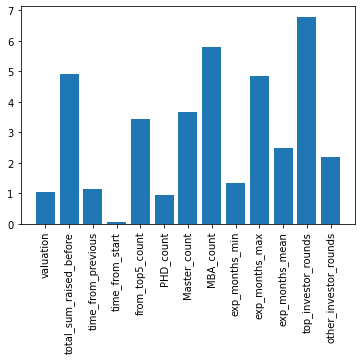

In [25]:
selector = SelectKBest(f_classif, k='all')
selector.fit(X_train_t, y_train)

#самый большой результат соответствует самому малому значению p-значения(вероятность ошибки)
#поэтому "переворачиваем", чтоб самые ценные признаки на графике были максимальными
scores = -np.log10(selector.pvalues_)

plt.bar(range(len(features)), scores)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [26]:
wave1_acc = []
wave1_PR = []
wave1_RC = []
wave1_features = []

### Sklearn Random Forest

In [27]:
param_grid1 = {
    'bootstrap': [True, False],
    'max_depth': [None, 25, 50, 75, 100],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
}

estimator1 = RandomForestClassifier()
grid_search1 = GridSearchCV(estimator = estimator1, param_grid = param_grid1, cv = 5, n_jobs = -1, verbose = 2, scoring='accuracy')
grid_search1.fit(X_train_t, y_train)
grid_search1.best_params_

Fitting 5 folds for each of 990 candidates, totalling 4950 fits


{'bootstrap': False,
 'max_depth': 75,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 30}

In [28]:
acc_array = []
PR_array = []
RC_array = []
f1_array = []
feature_array = []
best_grid1 = grid_search1.best_estimator_
for j in range(10):
    best_grid1.fit(X_train_t, y_train)
    predicted_labels = best_grid1.predict(X_test_t)
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels, average = 'macro')
    PR = precision_score(y_test, predicted_labels, average = 'macro')
    RC = recall_score(y_test, predicted_labels, average = 'macro')
    acc_array.append(acc)
    PR_array.append(PR)
    RC_array.append(RC)
    f1_array.append(f1)
    feature_array.append(best_grid1.feature_importances_)
print(f'acc = {np.mean(acc_array)}')
print(f'PR = {np.mean(PR_array)}')
print(f'RC = {np.mean(RC_array)}')
print(f'f1 = {np.mean(f1_array)}')

acc = 0.6707482993197279
PR = 0.6436648930511909
RC = 0.6192292490118576
f1 = 0.6212032452524945


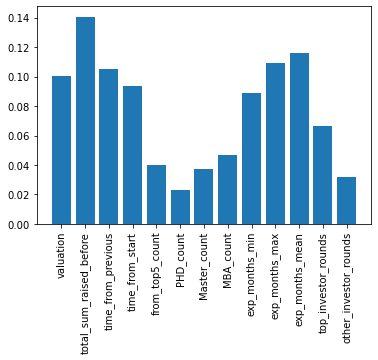

In [29]:
plt.bar(range(len(features)), best_grid1.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [30]:
wave1_acc.append(np.mean(acc_array))
wave1_PR.append(np.mean(PR_array))
wave1_RC.append(np.mean(RC_array))
wave1_features.append(np.average(feature_array, axis=0))

### Sklearn Gradient Boosting

In [31]:
param_grid2 = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [None, 25, 50, 75, 100],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [20, 50, 60, 70, 80, 90, 100, 110]
}

estimator2 = GradientBoostingClassifier()
grid_search2 = GridSearchCV(estimator = estimator2, param_grid = param_grid2, cv = 5, n_jobs = -1, verbose = 2, scoring='accuracy')
grid_search2.fit(X_train_t, y_train)
grid_search2.best_params_

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


{'learning_rate': 0.1,
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 70}

In [32]:
acc_array = []
f1_array = []
PR_array = []
RC_array = []
feature_array = []
best_grid2 = grid_search2.best_estimator_
for j in range(10):
    best_grid2.fit(X_train_t, y_train)
    predicted_labels = best_grid2.predict(X_test_t)
    acc = accuracy_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels, average = 'macro')
    PR = precision_score(y_test, predicted_labels, average = 'macro')
    RC = recall_score(y_test, predicted_labels, average = 'macro')
    acc_array.append(acc)
    PR_array.append(PR)
    RC_array.append(RC)
    f1_array.append(f1)
    feature_array.append(best_grid2.feature_importances_)
print(f'acc = {np.mean(acc_array)}')
print(f'PR = {np.mean(PR_array)}')
print(f'RC = {np.mean(RC_array)}')
print(f'f1 = {np.mean(f1_array)}')

acc = 0.6659863945578232
PR = 0.6389538857520856
RC = 0.6293181818181819
f1 = 0.6317917465073344


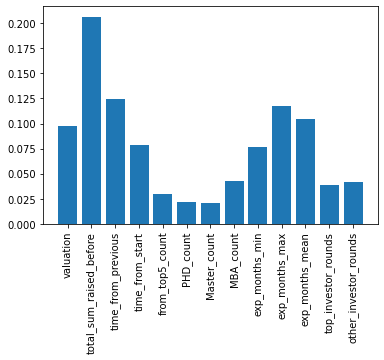

In [33]:
plt.bar(range(len(features)), best_grid2.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [34]:
wave1_acc.append(np.mean(acc_array))
wave1_PR.append(np.mean(PR_array))
wave1_RC.append(np.mean(RC_array))
wave1_features.append(np.average(feature_array, axis=0))

### XGBoost

In [35]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

estimator = XGBClassifier(objective="binary:logistic")
grid_search = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3, scoring="accuracy") #verbose = 2, scoring='accuracy' roc_auc
grid_search.fit(X_train_t, y_train)
grid_search.best_params_

[13:33:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Barca\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'colsample_bytree': 0.5,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_lambda': 0,
 'scale_pos_weight': 5,
 'subsample': 0.8}

In [36]:
grid_search.best_score_

0.6587388801674515

In [37]:
# best_grid = grid_search.best_estimator_
best_grid = XGBClassifier(objective="binary:logistic", **grid_search.best_params_)
best_grid.fit(X_train_t, y_train)

[13:33:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=5, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
predicted_labels = best_grid.predict(X_test_t)

roc_auc = roc_auc_score(y_test, predicted_labels)
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average = 'macro')
PR = precision_score(y_test, predicted_labels, average = 'macro')
RC = recall_score(y_test, predicted_labels, average = 'macro')

print(f'acc = {acc}')
print(f'PR = {PR}')
print(f'RC = {RC}')
print(f'f1 = {f1}')

acc = 0.6598639455782312
PR = 0.6360655737704918
RC = 0.5820158102766798
f1 = 0.5706775700934579


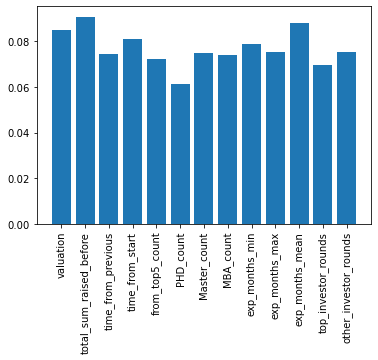

In [39]:
plt.bar(range(len(features)), best_grid.feature_importances_)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

In [40]:
wave1_acc.append(acc)
wave1_PR.append(PR)
wave1_RC.append(RC)
wave1_features.append(best_grid.feature_importances_)

In [41]:
wave1_acc

[0.6707482993197279, 0.6659863945578232, 0.6598639455782312]

In [42]:
wave1_PR

[0.6436648930511909, 0.6389538857520856, 0.6360655737704918]

In [43]:
wave1_RC

[0.6192292490118576, 0.6293181818181819, 0.5820158102766798]

In [44]:
wave1_features

[array([0.09350735, 0.1484403 , 0.11366422, 0.093699  , 0.04029788,
        0.02385343, 0.03975871, 0.05087873, 0.08436933, 0.10928839,
        0.11763424, 0.0540612 , 0.03054723]),
 array([0.0945196 , 0.19979039, 0.12026119, 0.08718537, 0.03203885,
        0.02636677, 0.02315818, 0.04366622, 0.07676767, 0.11501985,
        0.10119905, 0.03762942, 0.04239746]),
 array([0.08482073, 0.09065142, 0.07431813, 0.08116167, 0.072207  ,
        0.06114573, 0.07481118, 0.07407435, 0.07887403, 0.07510804,
        0.08801244, 0.06955853, 0.07525677], dtype=float32)]

In [45]:
wave1real_df = pd.DataFrame(list(zip([wave1_acc[0]], [wave1_acc[1]], [wave1_acc[2]])), 
               columns =['Random Forest', 'Gradient Boosting', 'XGBoost Classifier'])
wave1realf_df = pd.DataFrame(list(zip(wave1_features[0], wave1_features[1], wave1_features[2])), 
               columns =['Random Forest', 'Gradient Boosting', 'XGBoost Classifier'])
features = features.insert(0, 'ACCURACY')
parameters = pd.DataFrame(list(features), columns =['Parameter'])
wave1real_df = wave1real_df.append(wave1realf_df).reset_index(drop=True)
wave1real_df = pd.concat([parameters, wave1real_df], axis=1)
wave1real_df.to_csv('wave1_no_val_people_results.csv', encoding = 'utf-8-sig')
wave1real_df

,Parameter,Random Forest,Gradient Boosting,XGBoost Classifier
0,ACCURACY,0.670748,0.665986,0.659864
1,valuation,0.093507,0.094520,0.084821
2,total_sum_raised_before,0.148440,0.199790,0.090651
3,time_from_previous,0.113664,0.120261,0.074318
4,time_from_start,0.093699,0.087185,0.081162
5,from_top5_count,0.040298,0.032039,0.072207
6,PHD_count,0.023853,0.026367,0.061146
7,Master_count,0.039759,0.023158,0.074811
8,MBA_count,0.050879,0.043666,0.074074
9,exp_months_min,0.084369,0.076768,0.078874


### На единичных признаках

In [39]:
y = dataset[['not_dead']]
y = y.values.ravel()
X_general = dataset.drop(columns=['class', 'not_dead', 'exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'total_count', 'count_per_round', 'exp_months_std', 'interpolated_money_valuation_usd', 'total_sum_raised', 'lnP', 'log_delta', 'top_investor', 'other_investor'])

skaler = StandardScaler()
param_grid = {
    'bootstrap': [True, False], #rf only
#    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], #boosting only
    'max_depth': [None, 25, 50, 75, 100],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
}
estimator = RandomForestClassifier() #0.65-0.71
#estimator = GradientBoostingClassifier() #0.6-0.66
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2, scoring='accuracy')

X_general.columns

Index(['time_from_2009', 'time_from_start', 'time_from_previous',
       'top_investor_count', 'other_investor_count', 'top_investor_sum',
       'other_investor_sum', 'top_investor_rounds', 'other_investor_rounds',
       'top_quantil', 'is_PHD', 'is_Master', 'is_MBA', 'exp_months_min',
       'exp_months_max', 'exp_months_mean', 'total_sum_raised_before',
       'valuation', 'log_rate'],
      dtype='object')

In [44]:
mean_acc = []
mean_f1 = []
features = ['time_from_2009', 'time_from_start', 'time_from_previous',
       'top_investor_count', 'other_investor_count', 'top_investor_sum',
       'other_investor_sum', 'top_investor_rounds', 'other_investor_rounds',
       'from_top5_count', 'PHD_count', 'Master_count', 'MBA_count', 'exp_months_min',
       'exp_months_max', 'exp_months_mean', 'total_sum_raised_before',
       'valuation', 'val_rate']
for i in features:
    X = X_general[[i]]
    X = X.values.astype(np.float)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train_t = skaler.fit_transform(X_train)
    X_test_t = skaler.transform(X_test)
    grid_search.fit(X_train_t, y_train)
    best_grid = grid_search.best_estimator_
    
    acc_array = []
    f1_array = []
    PR_array = []
    RC_array = []
    for j in range(10):
        best_grid.fit(X_train_t, y_train)
        predicted_labels = best_grid.predict(X_test_t)
        acc = accuracy_score(y_test, predicted_labels)
        f1 = f1_score(y_test, predicted_labels, average = 'macro')
        PR = precision_score(y_test, predicted_labels, average = 'macro')
        RC = recall_score(y_test, predicted_labels, average = 'macro')
        acc_array.append(acc)
        PR_array.append(PR)
        RC_array.append(RC)
        f1_array.append(f1)
    mean_acc.append(np.mean(acc_array))
    mean_f1.append(np.mean(f1_array))
    #print(f'acc on {i} = {np.mean(acc_array)}')
    #print(f'f1 on {i} = {np.mean(f1_array)}')
mean_acc_f1_df = pd.DataFrame(list(zip(mean_acc, mean_f1)), 
               columns =['Accuracy', 'F-Score']).set_index([features])
print(mean_acc_f1_df)

Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1028 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 3620 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   41.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   40.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   39.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   34.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   34.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   34.9s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   34.7s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   34.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   34.1s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   34.2s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   33.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   34.2s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   34.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   37.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   40.6s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   40.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   38.7s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   37.0s finished


Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1224 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 1954 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 2844 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 3898 tasks      | elapsed:   32.5s


                         Accuracy   F-Score
time_from_2009           0.648649  0.647619
time_from_start          0.480180  0.463604
time_from_previous       0.466667  0.466340
top_investor_count       0.634234  0.632031
other_investor_count     0.495495  0.474203
top_investor_sum         0.506306  0.505711
other_investor_sum       0.518919  0.515798
top_investor_rounds      0.598198  0.556082
other_investor_rounds    0.459459  0.455882
top_quantil              0.548649  0.524318
is_PHD                   0.574775  0.568179
is_Master                0.526126  0.526111
is_MBA                   0.613514  0.610001
exp_months_min           0.567568  0.565841
exp_months_max           0.518919  0.513704
exp_months_mean          0.500901  0.499190
total_sum_raised_before  0.581081  0.569306
valuation                0.548649  0.547730
log_rate                 0.541441  0.531766


[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:   40.4s finished


In [45]:
mean_acc_f1_df

,Accuracy,F-Score
time_from_2009,0.648649,0.647619
time_from_start,0.480180,0.463604
time_from_previous,0.466667,0.466340
top_investor_count,0.634234,0.632031
other_investor_count,0.495495,0.474203
top_investor_sum,0.506306,0.505711
other_investor_sum,0.518919,0.515798
top_investor_rounds,0.598198,0.556082
other_investor_rounds,0.459459,0.455882
top_quantil,0.548649,0.524318


In [76]:
# acc_train = []
# acc_test = []
# f1_train = []
# f1_test = []
# for i in range(1, 101):
#     #classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100, C=0.12, penalty='l1', n_jobs=-1) #меньше 0.6
#     #classifier = KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs =-1) #отвратительное качество
#     classifier = DecisionTreeClassifier(max_depth=100) #качество на уровне 0.65-0.7
    
#     #ensemble_classifier = BaggingClassifier(base_estimator=classifier, n_estimators=i, bootstrap=True, n_jobs=-1)
#     ensemble_classifier = RandomForestClassifier(n_estimators=i, n_jobs=-1) #качество на уровне 0.65-0.7
#     #ensemble_classifier = GradientBoostingClassifier(n_estimators=i, learning_rate=0.2, max_depth=10) #качество на уровне 0.6-0.7
    
#     ensemble_classifier.fit(X_train_t, y_train)
#     class_names = ensemble_classifier.classes_
#     y_train_b = label_binarize(y_train, class_names)
#     y_test_b = label_binarize(y_test, class_names)
#     y_predict_train_b = label_binarize(ensemble_classifier.predict(X_train_t), class_names)
#     y_predict_test_b = label_binarize(ensemble_classifier.predict(X_test_t), class_names)
#     acc_train.append(accuracy_score(y_train_b, y_predict_train_b))
#     f1_train.append(f1_score(y_train_b, y_predict_train_b, average='weighted'))
#     acc_test.append(accuracy_score(y_test_b, y_predict_test_b))
#     f1_test.append(f1_score(y_test_b, y_predict_test_b, average='weighted'))

# plt.figure(figsize=(7, 7))
# plt.plot(np.arange(1, 101), acc_train, label='accuracy train')
# plt.plot(np.arange(1, 101), f1_train, label='f1_score train')
# plt.plot(np.arange(1, 101), acc_test, label='accuracy test')
# plt.plot(np.arange(1, 101), f1_test, label='f1_score test')
# plt.xlabel('n_estimators')
# plt.ylabel('score')
# plt.legend()
# plt.grid()
# plt.show()

### LogReg, kNN, Decision Tree

In [17]:
#pg = {'C': np.linspace(0.01, 1, 10), 'penalty': ['l1', 'l2']}
#pg = {'n_neighbors': range(1, 21)}
#pg = {'max_depth': np.linspace(1, 100, 5)}

#classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=1000, n_jobs =-1) #lbfgs
#classifier = KNeighborsClassifier(weights='distance')
#classifier = DecisionTreeClassifier()

#grid_search = GridSearchCV(estimator=classifier, n_jobs = -1, param_grid=pg, cv=5, scoring='accuracy')
#grid_search.fit(X_train_t, y_train)

#grid_search.best_params_

In [18]:
#best_classifier = grid_search.best_estimator_
#best_classifier.fit(X_train_t, y_train)

In [19]:
#predicted_labels = best_classifier.predict(X_test_t)

#acc = accuracy_score(y_test, predicted_labels)
#print(f'acc = {acc}')
#f1 = f1_score(y_test, predicted_labels, average = 'macro')
#print(f'f1 = {f1}')

In [20]:
#predict_proba = grid_search.predict_proba(X_test_t)
#for i in predict_proba:
#    print(i)

In [21]:
#class_names = grid_search.best_estimator_.classes_
#y_predict = grid_search.predict_proba(X_test_t)

##y_test_b = label_binarize(y_test, class_names)
#lb = LabelBinarizer()
#y_test_b = lb.fit_transform(y_test)
#y_test_b = np.hstack((1 - y_test_b, y_test_b))

#fpr = dict()
#tpr = dict()
#roc_auc = dict()
#for i in range(len(class_names)):
#    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_predict[:, i])
#    roc_auc[i] = auc(fpr[i], tpr[i])
    
##для микро
#fpr['micro'], tpr['micro'], _ = roc_curve(y_test_b.ravel(), y_predict.ravel())
#roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

##макро
#all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
#mean_tpr = np.zeros_like(all_fpr)
#for i in range(len(class_names)):
#    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
#mean_tpr /= len(class_names)
#fpr['macro'] = all_fpr
#tpr['macro'] = mean_tpr
#roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

##графики
#plt.figure(figsize=(6,6))
#plt.plot(fpr['micro'], tpr['micro'], label='micro, auc = %.3f'%(roc_auc['micro']), linestyle='--')
#plt.plot(fpr['macro'], tpr['macro'], label='macro, auc = %.3f'%(roc_auc['macro']), linestyle='--')
#for i in range(len(class_names)):
#    plt.plot(fpr[i], tpr[i], label='class = %s, auc = %.3f'%(class_names[i], auc(fpr[i], tpr[i])))

#plt.title('ROC-Кривая')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.legend()
#plt.show()

### Сокращение размерности

In [34]:
#pca = PCA()
#pca.fit(X_train_t)

#variance = np.cumsum(pca.explained_variance_ratio_)

#plt.figure(figsize=(5,5))
#plt.plot(variance)
#plt.xlabel('Components')
#plt.ylabel('EVR')
#plt.plot([0,46],[0.95,0.95])
#plt.show()

In [35]:
#pca = PCA(n_components=39)

#X_train_pca = pca.fit_transform(X_train_t)
#X_test_pca = pca.transform(X_test_t)

In [36]:
#pg = {'C': np.linspace(0.01, 1, 10), 'penalty': ['l1', 'l2']}
#pg = {'n_neighbors': range(1, 31)}
#pg = {'max_depth': np.linspace(1, 100, 5)}

In [37]:
#classifier = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=100, n_jobs =-1) #lbfgs
#classifier = KNeighborsClassifier(weights='distance')
#classifier = DecisionTreeClassifier()

#grid_search = GridSearchCV(estimator=classifier, n_jobs = -1, param_grid=pg, cv=5, scoring='accuracy')
#grid_search.fit(X_train_pca, y_train)

#grid_search.best_params_

In [38]:
#predicted_labels = grid_search.predict(X_test_pca)

#acc = accuracy_score(y_test, predicted_labels)
#f1 = f1_score(y_test, predicted_labels, average='weighted')
#print('acc = ', acc)
#print('f1 = ', f1)

### Catboost

In [63]:
y = dataset[['not_dead']] #'not_dead' 'exit_type' 'class'
X = dataset.drop(columns=['class', 'not_dead', 'exit_type', 'top_investor', 'other_investor', 'total_sum_raised', 'first_last_dif', 'stadia', 'investment_type', 'log_delta', 'price_usd', 'money_raised_usd', 'exp_months_std', 'funding_round_uuid', 'company_name', 'company_uuid', 'announced_on', 'exit_date', 'total_count', 'count_per_round', 'raised_amount_usd', 'post_money_valuation_usd', 'interpolated_money_valuation_usd', 'lnP'])

#только признаки команды (образование + опыт)
#X = X.drop(columns=['time_from_2009', 'time_from_previous', 'time_from_start', 'top_investor_sum', 'other_investor_sum', 'total_sum_raised_before', 'valuation', 'val_rate'])

#только инвестора и раунды
X = X[['valuation', 'val_rate', 'total_sum_raised_before', 'time_from_2009', 'time_from_previous', 'time_from_start', 'top_investor_sum', 'other_investor_sum']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

skaler = StandardScaler()
X_train_t = skaler.fit_transform(X_train)
X_eval_t = skaler.fit_transform(X_eval)
X_test_t = skaler.transform(X_test)

In [64]:
model = CatBoostClassifier(has_time=True, iterations=1000, depth=10, learning_rate=0.1, loss_function='CrossEntropy')
model.fit(X_train_t, y_train, eval_set=(X_eval_t, y_eval), verbose=100)

print ('CatBoost: prediction of %s: RMSLE on test = %s' % ('not_dead', model.evals_result_['validation']['CrossEntropy'][-1]))

0:	learn: 0.6514671	test: 0.6741755	best: 0.6741755 (0)	total: 155ms	remaining: 2m 34s
100:	learn: 0.0489779	test: 0.6215706	best: 0.5913487 (16)	total: 1.58s	remaining: 14.1s
200:	learn: 0.0177040	test: 0.6744059	best: 0.5913487 (16)	total: 2.9s	remaining: 11.6s
300:	learn: 0.0101371	test: 0.7124593	best: 0.5913487 (16)	total: 4.2s	remaining: 9.76s
400:	learn: 0.0069237	test: 0.7399347	best: 0.5913487 (16)	total: 5.55s	remaining: 8.29s
500:	learn: 0.0053840	test: 0.7578491	best: 0.5913487 (16)	total: 6.87s	remaining: 6.84s
600:	learn: 0.0044076	test: 0.7763442	best: 0.5913487 (16)	total: 8.21s	remaining: 5.45s
700:	learn: 0.0038291	test: 0.7896251	best: 0.5913487 (16)	total: 9.62s	remaining: 4.1s
800:	learn: 0.0033698	test: 0.7988073	best: 0.5913487 (16)	total: 10.9s	remaining: 2.72s
900:	learn: 0.0030590	test: 0.8067507	best: 0.5913487 (16)	total: 12.3s	remaining: 1.35s
999:	learn: 0.0028825	test: 0.8127623	best: 0.5913487 (16)	total: 13.7s	remaining: 0us

bestTest = 0.5913486676
bes

In [65]:
y_pred = model.predict(X_test_t)
y_pred

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0],
      dtype=int64)

In [66]:
y_test = y_test.values.ravel()
y_test

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.])

In [67]:
print ('\nCatBoost: prediction of %s. Feature importance. Type=PredictionValuesChange' % 'log_delta')
print (model.get_feature_importance(type=cb.EFstrType.PredictionValuesChange, prettified=True).head(25).to_string())


CatBoost: prediction of log_delta. Feature importance. Type=PredictionValuesChange
  Feature Id  Importances
0          6    19.197516
1          3    18.696240
2          0    17.847655
3          7    12.064020
4          2     9.962412
5          4     8.120351
6          5     7.730078
7          1     6.381729


In [68]:
model.score(X_test_t, y_test)

0.6564885496183206